# Netzwerk mit übereinstimmenden Tagesordnungspunkten als Gewichte

#### Laden:

In [22]:
import json
import requests
import collections
import time
from tqdm import tqdm

In [23]:
with open('../data/speeches_19_preprocessed.json', 'r') as fp:
    data = json.load(fp)
    
alleReden = data.copy()

In [24]:
reden = alleReden

#### Filtern auf Meta-Informationen:

In [25]:
def filter_reden(reden):
    
    redeinfo_list = []
    
    for rede in reden:

        input_dict = {
        'date'  : rede["date"],
        'discussion_title' : rede["discussion_title"],
        'name'  : rede["name"],
        'party' : rede["party"],
        }
        redeinfo_list.append(input_dict)
        
    return redeinfo_list


In [26]:
redeinfo_list = filter_reden(reden)

#### Liste aller Parlamentarier:

In [27]:
def liste_aller_parlamentarier(reden):
    
    names = []
    
    for rede in reden:
        if rede['name'] not in names:
            names.append(rede['name'])
    
    return names
    

In [28]:
names = liste_aller_parlamentarier(redeinfo_list)

#### Restrukturierung der Daten

Die Daten werden in eine Liste von Dictionaries übertragen. Jeder Parlamentarier erhält ein Dictionary in dieser Liste, wobei jedes Dictionary eine Liste mit den TOPs, in denen der jeweilige Parlamentarier gesprochen hat, erhält.
Zusätzlich enthält jedes Dictionary eine ID.

In [29]:
def liste_von_parla_mit_dict(reden, names):
    
    parlamentarier = []

    for count,name in tqdm(enumerate(names)):
        hilf = {
            'id':count+1,
            'name': name,
            'text_lem': []
        }
        tops = []
        text = []
        for rede in reden:
            if rede['name'] == name:
                text = text + rede['text_lem']
                hilf.update({'party': rede['party']})
                
                if rede['discussion_title'] not in tops:
                    tops.append(rede['discussion_title'])
                    #print(rede['discussion_title'])
                    
        hilf.update({'tops': tops,'text_lem':text})
        parlamentarier.append(hilf)
    
    return parlamentarier

In [30]:
parlamentarier = liste_von_parla_mit_dict(reden, names)

781it [00:06, 128.91it/s]


In [32]:
#print(parlamentarier[1])

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [ " ".join(parla['text_lem']) for parla in parlamentarier ]
vectorizer = CountVectorizer(max_df=0.8, min_df=(2/781))
f_word = vectorizer.fit_transform(corpus)

In [34]:
import numpy as np

In [35]:
for count, name in tqdm(enumerate(parlamentarier)):
    
    vec_numbers = np.array(f_word.getrow(count).toarray()[0])
    msw = list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(np.argmax(vec_numbers))]
    name.update({'msw':msw})

781it [00:05, 152.70it/s]


#### Erstellen der Kanten des coTOP-Graphen

In [36]:
def cotop_graph_erstellen(parlamentarier, min_weight):

    graph = {
        'directed': False,
        'graph': 'coTOP_graph',
        'links': [],
        'nodes': parlamentarier,
    }

    for ix,nodeI in enumerate(graph['nodes']):
        for jx,nodeJ in enumerate(graph['nodes']):
            if nodeI['id'] < nodeJ['id']:
                source = nodeI['id']
                target = nodeJ['id']
                topsI = set(nodeI['tops'])
                topsJ = set(nodeJ['tops'])
                weight = len(topsI.intersection(topsJ))  # length of intersection as weight
                if weight >= min_weight:
                    link_dict = {
                        'source':source,
                        'target':target,
                        'weight':weight       
                    }
                    graph['links'].append(link_dict)
    return graph

In [39]:
graph = cotop_graph_erstellen(parlamentarier, 2)

##### Auswerten der Anzahl der Kanten

This graph has 781 nodes and 21429 links.


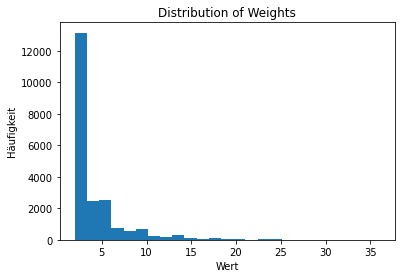

In [40]:
nn = len(graph['nodes'])
ne = len(graph['links'])
print( f"This graph has {nn} nodes and {ne} links.")

import matplotlib.pyplot as plt

weights=[]
for link in graph['links']:
    weights.append(link['weight'])
#print(sum(weights))

plt.hist(weights, bins=25)
plt.title("Distribution of Weights")
plt.xlabel("Wert")
plt.ylabel("Häufigkeit")
plt.show()

#### Draw the HTML/JS Graph

In der Tat: 50000 Kanten ist viel. Vielleicht auch zu viel für Gephi. Wir werden sehen. Aber darüber hinaus habe ich irgendwie nicht erwartet, dass diese Graphen so dicht (viele Kanten) sind. 

(Nun wissen wir, dass es teilweise sehr viele Redner per TOP gibt, siehe unten.)

#### Dauert sehr lange. Skip!

In [17]:
def visualize_cotop_graph(graph):
    
    json = {'data': graph,
            'nodecoloring': 'party',
            'nodelabel': 'name',
            "darkmode": False,
            "edgevisibility": False,
            "particles": False
            }
    print("previsualizer")
    result = requests.post('https://penelope.vub.be/network-components/visualiser', json=json)
    print("presave")
    with open(f"./redenetTOPS.html", "w", encoding='utf-8') as f:
        f.write(result.json()['graph'])
    print("savedone")

visualize_cotop_graph(graph)

previsualizer


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

### Convert to Gephi-readable File

Also versuchen wir Gephi. Wir brauchen die networkx package.

In [41]:
import networkx as nx

In [42]:
def conv_penelope_to_networkx(graph):
    graph_nx = nx.Graph()
    
    for node in graph['nodes']:
        graph_nx.add_node(node['id'], name=node['name'], party=node['party'], msw=node['msw'])

    print('nodes done')
    
    for link in graph['links']:   
        graph_nx.add_edge(link['source'],link['target'],weight = link['weight'])
    print('links done')   
    
    return graph_nx

def save_coTOP(graph_nx, dateiname):
    nx.write_gexf(graph_nx, dateiname)
    print('save done')

In [43]:
graph_nx = conv_penelope_to_networkx(graph)

nodes done
links done


In [44]:
save_coTOP(graph_nx, "graph_coTOP_19.gexf")

save done
